# Adding Statistic Annotations

Sources and inspiration:


*   https://www.kaggle.com/code/tirendazacademy/penguin-dataset-data-visualization-with-seaborn#Penguin-Dataset:-Data-Visualization-with-Seaborn
*   https://seaborn.pydata.org/tutorial/categorical.html
* https://pandas.pydata.org/docs/user_guide/visualization.html
* https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00



needed packages:
 * pandas
 * seaborn
 * statannotations
 * numpy (stat. anotations, already part of pandas)
 * scipy (stat. anotations)

support package
 * watermark (documenting version of packages)

In [7]:
#!pip install pandas
#!pip install seaborn
#!pip install scipy
!pip install watermark
!pip install statannotations

## Seaborn with statistics annotations

### Introduction

Many libraries are available in Python to clean, analyze, and plot data.
Python also has robust statistical packages which are used by thousands of other projects.

That said, if you wish, basically, to add statistics to your plots, with the beautiful brackets as you can see in papers
using R or other statistical software, there are not many options.


In this part, we will use `statannotations`, a package to add statistical significance annotations on seaborn
categorical plots.

We will first setup the required tools, then describe the dataset we'll work on.

Specifically, after showing how to install and import statannotations, we will answer the following questions:
- How to add custom annotations to a seaborn plot?
- How to automatically format previously computed p-values in several different ways, then add these to a plot in a
  single function call?
- How to both perform the statistical tests and add their results to a plot, optionally applying a multiple comparisons
  correction method?

**DISCLAIMER**: This tutorial aims to describe *how to use a plot annotation library, not to teach statistics*. The
examples are meant only to illustrate the plots, not the statistical methodology, and we will not draw any conclusions
about the dataset explored.

A correct approach would have required the careful definition of a research question based, evaluation how the data acquisitions and
maybe, ultimately, different group comparisons and/or tests. Of course, the p-value is not the right answer for
everything either. *But the aim is to learn how to aproach this so you can later easily reuse the notebooks, charts and even share it with your research!*

### Preparing the tools
First, let's prepare the tools we'll need, namely `pandas`, `numpy`, `pyplot`, `scipy`, and of course `seaborn`, plus a
few additional functions.

#### Imports

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


import numpy as np
from scipy.stats import mannwhitneyu, normaltest

Clean Penguins dataset

In [9]:
penguins = sns.load_dataset("penguins")
penguins_cleaned = penguins.dropna()

### Exploring the Data

We already prepared the penguin dataset with `penguins_cleaned = penguins.dropna()`, but we should double check.

In [10]:
penguins_cleaned.isnull().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [11]:
penguins_cleaned.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [12]:
penguins_cleaned['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

From previous section we know that there are 3 species of penquins, which we can compare through some of the values available.

In [13]:
penguins_cleaned.pivot_table('bill_length_mm', index='sex', columns='species', aggfunc='mean')

species,Adelie,Chinstrap,Gentoo
sex,,,
Female,37.257534,46.573529,45.563793
Male,40.390411,51.094118,49.473770


In [14]:
Adelie_values =  penguins_cleaned[penguins_cleaned['species']=='Adelie']
Chinstrap_values = penguins_cleaned[penguins_cleaned['species']=='Chinstrap']
Gentoo_values = penguins_cleaned[penguins_cleaned['species']=='Gentoo']

In [15]:
Adelie_values.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,146.000000,146.000000,146.000000,146.000000
mean,38.823973,18.347260,190.102740,3706.164384
std,2.662597,1.219338,6.521825,458.620135
min,32.100000,15.500000,172.000000,2850.000000
25%,36.725000,17.500000,186.000000,3362.500000
50%,38.850000,18.400000,190.000000,3700.000000
75%,40.775000,19.000000,195.000000,4000.000000
max,46.000000,21.500000,210.000000,4775.000000


In [16]:
Chinstrap_values.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,68.000000,68.000000,68.000000,68.000000
mean,48.833824,18.420588,195.823529,3733.088235
std,3.339256,1.135395,7.131894,384.335081
min,40.900000,16.400000,178.000000,2700.000000
25%,46.350000,17.500000,191.000000,3487.500000
50%,49.550000,18.450000,196.000000,3700.000000
75%,51.075000,19.400000,201.000000,3950.000000
max,58.000000,20.800000,212.000000,4800.000000


In [17]:
Gentoo_values.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,119.000000,119.000000,119.000000,119.000000
mean,47.568067,14.996639,217.235294,5092.436975
std,3.106116,0.985998,6.585431,501.476154
min,40.900000,13.100000,203.000000,3950.000000
25%,45.350000,14.200000,212.000000,4700.000000
50%,47.400000,15.000000,216.000000,5050.000000
75%,49.600000,15.750000,221.500000,5500.000000
max,59.600000,17.300000,231.000000,6300.000000


Or, we can use `for` loop to describe our data for each unique species value. It will help us to get some insight, even though we might later need `DataFrame` for each of the species.

In [18]:
for spec in penguins_cleaned['species'].unique():
  print(spec)
  print(penguins_cleaned[penguins_cleaned['species']==spec].describe())
  print('--------------')

Adelie
       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count      146.000000     146.000000         146.000000   146.000000
mean        38.823973      18.347260         190.102740  3706.164384
std          2.662597       1.219338           6.521825   458.620135
min         32.100000      15.500000         172.000000  2850.000000
25%         36.725000      17.500000         186.000000  3362.500000
50%         38.850000      18.400000         190.000000  3700.000000
75%         40.775000      19.000000         195.000000  4000.000000
max         46.000000      21.500000         210.000000  4775.000000
--------------
Chinstrap
       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count       68.000000      68.000000          68.000000    68.000000
mean        48.833824      18.420588         195.823529  3733.088235
std          3.339256       1.135395           7.131894   384.335081
min         40.900000      16.400000         178.000000  2700.000000
25

#### Test normality

In [19]:
Adelie_values =  penguins_cleaned[penguins_cleaned['species']=='Adelie']
Chinstrap_values = penguins_cleaned[penguins_cleaned['species']=='Chinstrap']
Gentoo_values = penguins_cleaned[penguins_cleaned['species']=='Gentoo']

`normaltest()` test whether a sample differs from a normal distribution.

This function tests the null hypothesis that a sample comes from a normal distribution.

The p-value range is between 0 and 1,

In [20]:
from scipy.stats import normaltest
print("Adelie: ", normaltest(Adelie_values['bill_length_mm']).pvalue)
print("Chinstrap: ", normaltest(Chinstrap_values['bill_length_mm']).pvalue)
print("Gentoo: ", normaltest(Gentoo_values['bill_length_mm']).pvalue)


Adelie:  0.7046667395852243
Chinstrap:  0.9143668075479967
Gentoo:  0.002785628232779262


Traditionally, in statistics, we need a p-value of less than 0.05 to
reject the null hypothesis.  In this case, the 2 out of 3 species have p-value > 0.05.  Because our p value is greater than 0.05, we cannot reject the null hypothesis.  Therefore, we have not proven that the 2 data sets are different from normality.

But what about the last?

Aren't we forgeting something? Do we know enough about the data?

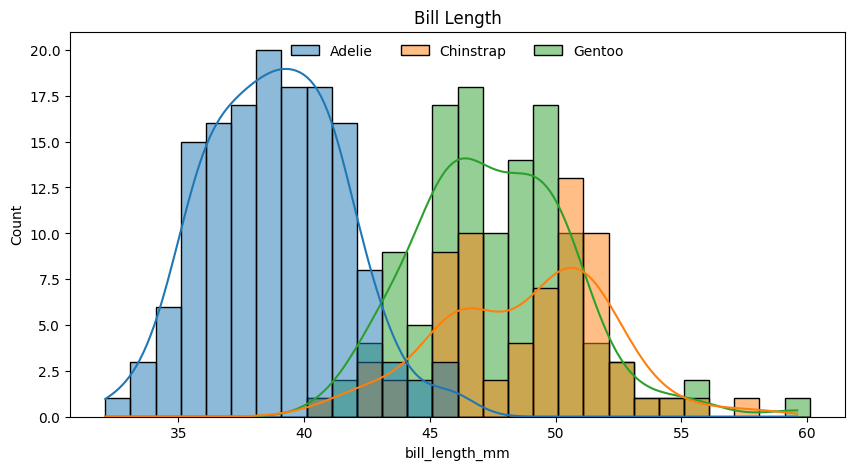

In [21]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

sns.histplot(x = "bill_length_mm", data = penguins_cleaned, binwidth=1, hue="species", kde=True)
# plt.title("Bill Length", size=20, color="red") # would look wierd
ax.set(title="Bill Length")

sns.move_legend(
    ax, "upper center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

A normal distribution is symmetric about the mean.  
A normal distribution also has a specific width for a given height.

If you double the height, the width scales proportionally.  However,
you could imagine stretching a bell curve out in weird ways without
changing its symmetry.  You could have a sharp, pointy distribution,
or a fat, boxy one.

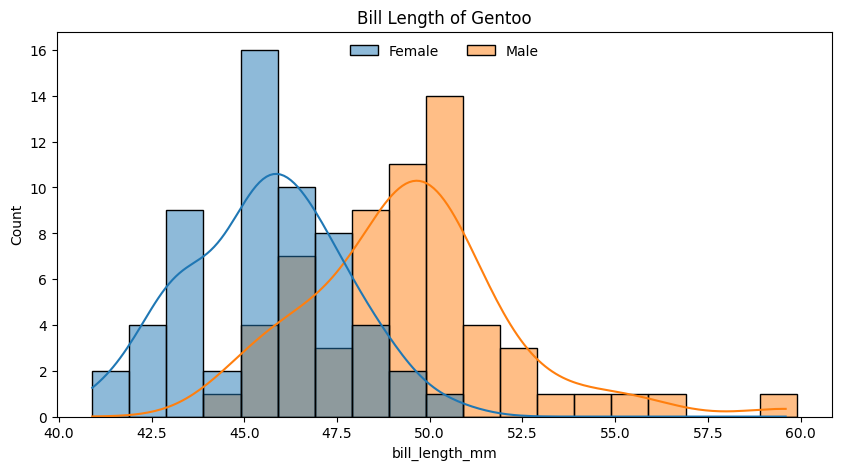

In [22]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

sns.histplot(x = "bill_length_mm", data = Gentoo_values, binwidth=1, hue="sex", kde=True)
# plt.title("Bill Length", size=20, color="red") # would look wierd
ax.set(title="Bill Length of Gentoo")

sns.move_legend(
    ax, "upper center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

In [23]:
Gentoo_values_male=Gentoo_values[Gentoo_values.sex=='Male']
Gentoo_values_female=Gentoo_values[Gentoo_values.sex=='Female']

print("Gentoo male: ", normaltest(Gentoo_values_male['bill_length_mm']).pvalue)
print("Gentoo female: ", normaltest(Gentoo_values_female['bill_length_mm']).pvalue)

Gentoo male:  0.0005453287292381343
Gentoo female:  0.9029679515828937


### Statistics

Luckily we are able to test and compare sets of values, even if they do not come from Normal Distribution

#### Parametric

`ttest_ind()` calculates the T-test for the means of two independent samples of scores.

This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

There is a catch! We need to have either same number of samples, or same variance. `ttest_ind()` can perform a standard independent 2 sample test that assumes equal population variances. If False, perform Welch’s t-test, which does not assume equal population variance.

---
**Note**
*Using Student's original definition of the t-test, the two populations being compared should have the same variance. If the sample sizes in the two groups being compared are equal, Student's original t-test is highly robust to the presence of unequal variances. Welch's t-test is insensitive to equality of the variances regardless of whether the sample sizes are similar.*

Perform Levene test for equal variances.

The Levene test tests the null hypothesis that all input samples are from populations with equal variances.

In [24]:
from scipy.stats import ttest_ind, levene

In [25]:
# pvalues with scipy:
stat_results = [levene(Adelie_values['bill_length_mm'], Chinstrap_values['bill_length_mm'])]

print("Adelie vs Chinstrap, variance: ", stat_results[0])

pvalues = [result.pvalue for result in stat_results]

Adelie vs Chinstrap, variance:  LeveneResult(statistic=4.529733833453024, pvalue=0.03446512682844295)


With p-value < 0.05 , we reject the null hypothesis that all input samples are from populations with equal variances. So we need Welch’s t-test

---
Null hypothesis is that 2 independent samples have identical average (expected) values.

In [26]:
# pvalues with scipy:
stat_results_ACh = [ttest_ind(Adelie_values['bill_length_mm'], Chinstrap_values['bill_length_mm'], equal_var=False)]

print("Adelie vs Chinstrap, mean: ", stat_results_ACh[0])

pvalues = [result.pvalue for result in stat_results_ACh]

Adelie vs Chinstrap, mean:  Ttest_indResult(statistic=-21.712498056635937, pvalue=3.1490764303457434e-41)


With p-value < 0.05 , we reject the null hypothesis. Now how we can plot this?

#### Non-parametric

In [27]:
from scipy.stats import mannwhitneyu

# pvalues with scipy:
stat_results_GFM = [mannwhitneyu(Gentoo_values_male['bill_length_mm'], Gentoo_values_female['bill_length_mm'], alternative="two-sided"),]

print("Gentoo male vs Gentoo female, bill_length_mm: ", stat_results_GFM[0])

pvalues = [result.pvalue for result in stat_results_GFM]

Gentoo male vs Gentoo female, bill_length_mm:  MannwhitneyuResult(statistic=3125.5, pvalue=5.58594267834405e-13)


### Statistic annotations

In [28]:
!pip install statannotations

In [29]:
from statannotations.Annotator import Annotator

## Use statannotations
The general pattern is
0. Decide which pairs of data you would like to annotate


1. Instantiate an `Annotator` (or reuse it on a new plot, we'll cover that later)


2. Configure it (text formatting, statistical test, multiple comparisons correction method...)


3. Make the annotations (we'll cover these cases)

    - By providing completely custom annotations (A)
    - By providing pvalues to be formatted before being added to the plot (B)
    - By applying a configured test (C)


4. Annotate !

If we already have a seaborn plot (and its associated `ax`), and statistical results, or any other text we would like to
 display on the plot, these are the detailed steps required.

**STEP 0**: What to compare

A pre-requisite to annotating the plot, is deciding which pairs you are comparing.
You'll pass which boxes (or bars, violins, etc) you want to annotate in a `pairs` parameter. In this case, it is the
equivalent of `'Adelie vs Chinstrap'` and others.

For statannotations, we specify this as a list of tuples like `('Adelie', 'Chinstrap')`

```python
pairs = [('Adelie', 'Chinstrap'),
         ('Adelie', 'Gentoo'),
         ('Chinstrap', 'Gentoo'),
         ]
```
**STEP 1**: The annotator

We now have all we need to instantiate the annotator
```python
annotator = Annotator(ax, pairs, ...)  # With ... = all parameters passed to seaborn's plotter
```

**STEP 2**: In this first example, we will not configure anything.

**STEP 3**: We'll then add the raw pvalues from scipy's returned values
```python

pvalues = [mannwhitneyu(Adelie_values['bill_length_mm'], Chinstrap_values['bill_length_mm']).pvalue,
           mannwhitneyu(Adelie_values['bill_length_mm'], Gentoo_values['bill_length_mm']).pvalue,
           mannwhitneyu(Chinstrap_values['bill_length_mm'], Gentoo_values['bill_length_mm']).pvalue]
```
using
```python
annotator.set_custom_annotations(pvalues)
```
**STEP 4**: Annotate !
```python
annotator.annotate()
```

(*) Make sure pairs and annotations (pvalues here) are in the same order

[Text(0.5, 1.0, 'Bill Length for 3 Penguin Species')]

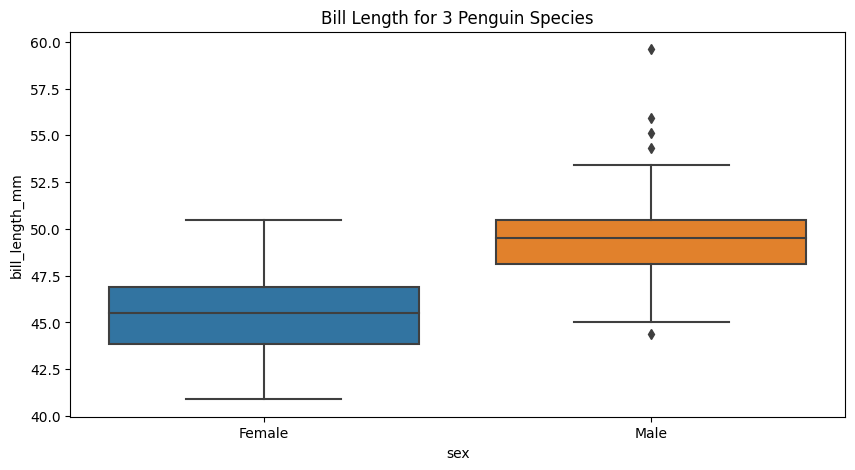

In [30]:
f, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(x = "sex",
            y = "bill_length_mm",
            data = Gentoo_values)

ax.set(title="Bill Length for 3 Penguin Species")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Female vs. Male: p=5.59e-13


[Text(0.5, 1.0, 'Bill Length for Gentoo, based on sex')]

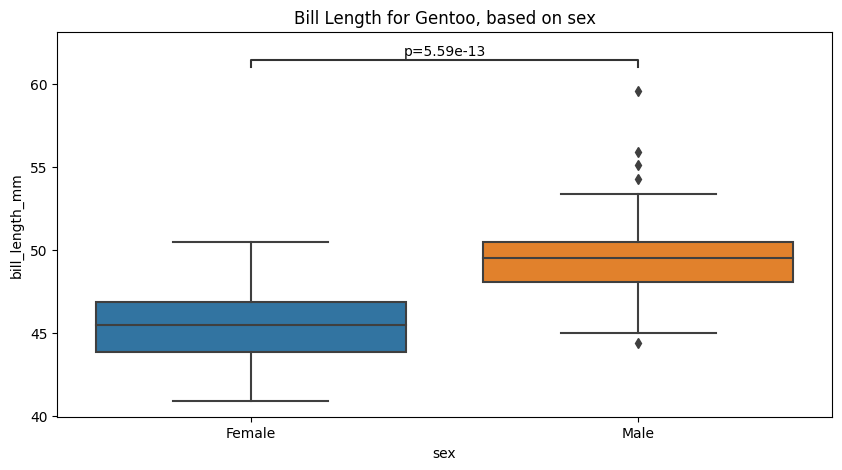

In [31]:
pairs = [('Female', 'Male'),
        #  ('data 1', 'data 2'),
         ]

from scipy.stats import mannwhitneyu

# pvalues with scipy, format based on pairs:
stat_results_GMF = [mannwhitneyu(Gentoo_values_female['bill_length_mm'], Gentoo_values_male['bill_length_mm'], alternative="two-sided"),]
pvalues = [result.pvalue for result in stat_results_GMF]

formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

# Create new plot
f, ax = plt.subplots(figsize=(10, 5))

plotting_parameters = {
    'data':Gentoo_values,
    'x':'sex',
    'y':'bill_length_mm',
}

# Plot with seaborn
sns.boxplot(**plotting_parameters)

# Add annotations
annotator = Annotator(ax, pairs, **plotting_parameters)
annotator.set_custom_annotations(formatted_pvalues)
annotator.annotate()

ax.set(title="Bill Length for Gentoo, based on sex")

### Use statannotations to apply scipy test

Finally, `statannotations` can take care of most of the steps required to run the test by calling `scipy.stats` directly
and annotate the plot.
The available options are

- Mann-Whitney
- t-test (independent and paired)
- Welch's t-test
- Levene test
- Wilcoxon test
- Kruskal-Wallis test

We will cover how to use a test that is not one of those already interfaced in `statannotations`.
If you are curious, you can also take a look at the usage
[notebook](https://github.com/trevismd/statannotations/blob/master/usage/example.ipynb) in the project repository.

### Simple

Adelie vs. Chinstrap: Mann-Whitney-Wilcoxon test two-sided, P_val:9.063e-31 U_stat=1.000e+02
Chinstrap vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.947e-03 U_stat=5.105e+03
Adelie vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.022e-42 U_stat=2.160e+02


[Text(0.5, 1.0, 'Bill Length Comparison')]

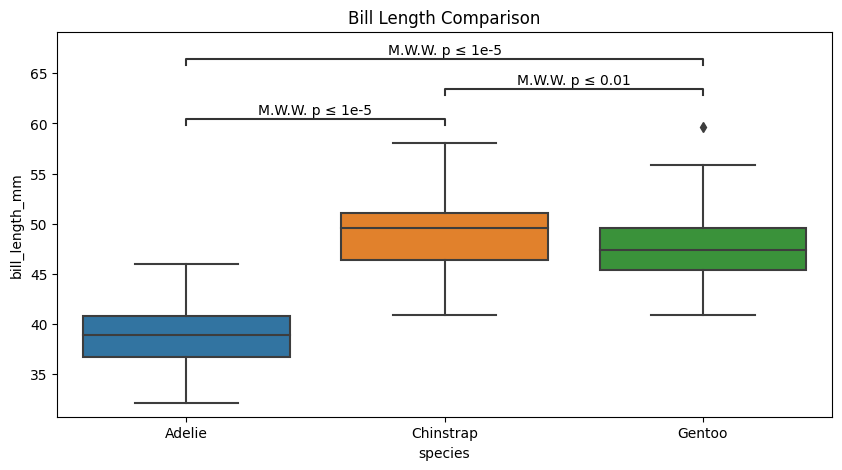

In [32]:
# Create new plot
f, ax = plt.subplots(figsize=(10, 5))

plotting_parameters = {
    'data':penguins_cleaned,
    'x':'species',
    'y':'bill_length_mm',
}

pairs = [('Adelie', 'Chinstrap'),
         ('Adelie', 'Gentoo'),
         ('Chinstrap', 'Gentoo'),
         ]


# Plot with seaborn
sns.boxplot(ax=ax, **plotting_parameters)

# Add annotations
annotator.new_plot(ax, pairs=pairs, **plotting_parameters)
annotator.configure(test='Mann-Whitney', text_format="simple", verbose=True).apply_and_annotate()

ax.set(title="Bill Length Comparison")

### Full

Adelie vs. Chinstrap: Mann-Whitney-Wilcoxon test two-sided, P_val:9.063e-31 U_stat=1.000e+02
Chinstrap vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.947e-03 U_stat=5.105e+03
Adelie vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.022e-42 U_stat=2.160e+02


[Text(0.5, 1.0, 'Bill Length Comparison')]

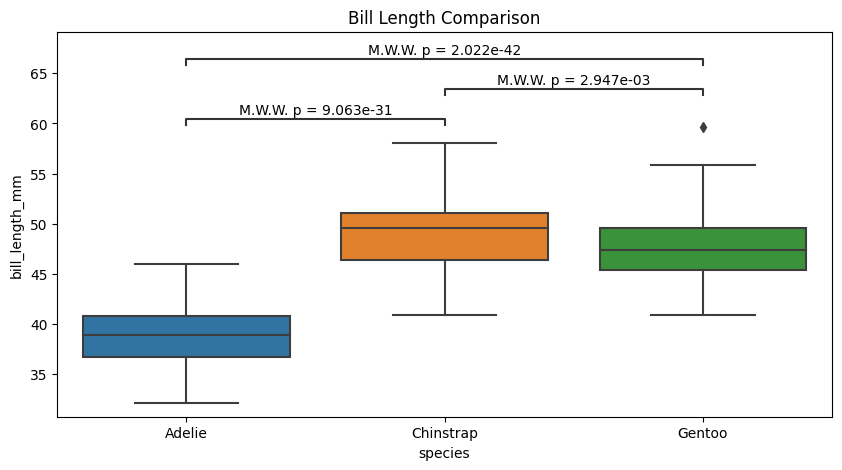

In [33]:
# Create new plot
f, ax = plt.subplots(figsize=(10, 5))

plotting_parameters = {
    'data':penguins_cleaned,
    'x':'species',
    'y':'bill_length_mm',
}

pairs = [('Adelie', 'Chinstrap'),
         ('Adelie', 'Gentoo'),
         ('Chinstrap', 'Gentoo'),
         ]


# Plot with seaborn
sns.boxplot(ax=ax, **plotting_parameters)

# Add annotations
annotator.new_plot(ax, pairs=pairs, **plotting_parameters)
annotator.configure(test='Mann-Whitney', text_format="full", verbose=True).apply_and_annotate()

ax.set(title="Bill Length Comparison")

### Star

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adelie vs. Chinstrap: Mann-Whitney-Wilcoxon test two-sided, P_val:9.063e-31 U_stat=1.000e+02
Chinstrap vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.947e-03 U_stat=5.105e+03
Adelie vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.022e-42 U_stat=2.160e+02


[Text(0.5, 1.0, 'Bill Length Comparison')]

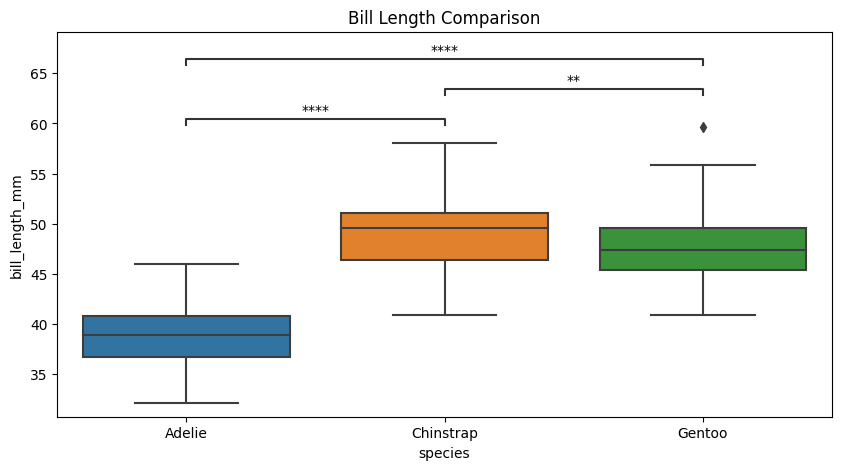

In [34]:
# Create new plot
f, ax = plt.subplots(figsize=(10, 5))

plotting_parameters = {
    'data':penguins_cleaned,
    'x':'species',
    'y':'bill_length_mm',
}

pairs = [('Adelie', 'Chinstrap'),
         ('Adelie', 'Gentoo'),
         ('Chinstrap', 'Gentoo'),
         ]


# Plot with seaborn
sns.boxplot(ax=ax, **plotting_parameters)

# Add annotations
annotator.new_plot(ax, pairs=pairs, **plotting_parameters)
annotator.configure(test='Mann-Whitney', text_format="star", verbose=True).apply_and_annotate()

ax.set(title="Bill Length Comparison")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adelie vs. Chinstrap: Mann-Whitney-Wilcoxon test two-sided, P_val:9.063e-31 U_stat=1.000e+02
Chinstrap vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.947e-03 U_stat=5.105e+03
Adelie vs. Gentoo: Mann-Whitney-Wilcoxon test two-sided, P_val:2.022e-42 U_stat=2.160e+02


[Text(0.5, 1.0, 'Bill Length Comparison of Penguin Species')]

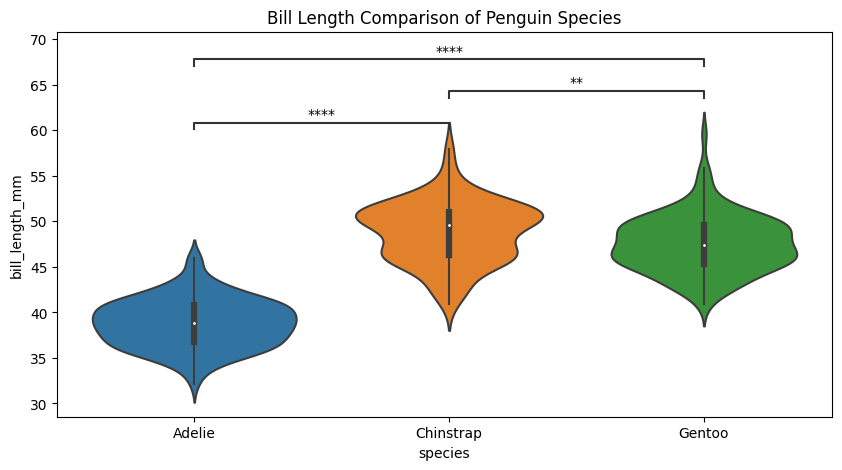

In [35]:
# Create new plot
f, ax = plt.subplots(figsize=(10, 5))

plotting_parameters = {
    'data':penguins_cleaned,
    'x':'species',
    'y':'bill_length_mm',
}

pairs = [('Adelie', 'Chinstrap'),
         ('Adelie', 'Gentoo'),
         ('Chinstrap', 'Gentoo'),
         ]


# Plot with seaborn
sns.violinplot(ax=ax, **plotting_parameters)

# Add annotations
annotator.new_plot(ax, pairs=pairs, **plotting_parameters)
annotator.configure(test='Mann-Whitney', text_format="star", verbose=True).apply_and_annotate()

ax.set(title="Bill Length Comparison of Penguin Species")

In [36]:
f.savefig('violin_annotated_PNG.png', dpi=300)

---

In [37]:
from watermark import watermark
watermark(iversions=True, globals_=globals())
print(watermark())
print(watermark(packages="watermark,numpy,pandas,seaborn,matplotlib,scipy,statannotations"))

Last updated: 2023-08-08T16:31:59.573995+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.109+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

watermark      : 2.4.3
numpy          : 1.22.4
pandas         : 1.5.3
seaborn        : 0.11.2
matplotlib     : 3.7.1
scipy          : 1.10.1
statannotations: 0.5.0

